In [1]:
import os
import pickle
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import transforms
from transformers import AutoTokenizer, DeiTFeatureExtractor

c:\Users\ENVY\OneDrive - Università degli Studi di Milano\Uni\Thesis\Project\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load Excel
df = pd.read_excel("AI FRACTURES/Fratture AI.xlsx")

# Create binary labels
labels = [1 if row["FRATTURA SI"] == "x" else 0 for _, row in df.iterrows()]
case_ids = [f"riga {i + 2}" for i in range(len(labels))]  # Matches your folder names

In [3]:
labels.count(1), labels.count(0)

(50, 49)

In [4]:
train_data, test_data, train_labels, test_labels = train_test_split(
    case_ids,
    labels,
    test_size=0.2,  # 80/20 split
    stratify=labels,  # keep fracture/no fracture ratio
    random_state=42
)

test_data, val_data, test_labels, val_labels = train_test_split(
    test_data,
    test_labels,
    test_size=0.5,  # 50/50 split for validation
    stratify=test_labels,  # keep fracture/no fracture ratio
    random_state=42
)

In [5]:
split_data = {
    "train": train_data,
    "test": test_data,
    "train_labels": train_labels,
    "test_labels": test_labels,
    "val": val_data,
    "val_labels": val_labels
}

with open("fracture_data_split.pkl", "wb") as f:
    pickle.dump(split_data, f)

In [6]:
import pickle

with open("fracture_data_split.pkl", "rb") as f:
    split_data = pickle.load(f)

train_data = split_data["train"]
test_data = split_data["test"]
train_labels = split_data["train_labels"]
test_labels = split_data["test_labels"]
val_data = split_data["val"]
val_labels = split_data["val_labels"]

In [7]:
feature_extractor = DeiTFeatureExtractor.from_pretrained("facebook/deit-tiny-patch16-224")

image_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std)
])

tokenizer = AutoTokenizer.from_pretrained("huawei-noah/TinyBERT_General_4L_312D")

root_dir = "AI FRACTURES"

c:\Users\ENVY\OneDrive - Università degli Studi di Milano\Uni\Thesis\Project\.venv\Lib\site-packages\transformers\models\deit\feature_extraction_deit.py:30: FutureWarning: The class DeiTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use DeiTImageProcessor instead.
  warnings.warn(


In [8]:
class FractureDataset(Dataset):
    def __init__(self, case_ids, labels, root_dir, image_transform, tokenizer, max_token_len=40):
        self.case_ids = case_ids
        self.labels = labels
        self.root_dir = root_dir
        self.image_transform = image_transform
        self.tokenizer = tokenizer
        self.max_token_len = max_token_len

    def __len__(self):
        return len(self.data_list)

    def __getitem__(self, idx):
        case_id, label = self.case_ids[idx], self.labels[idx]
        case_folder = os.path.join(self.root_dir, case_id)
        subfolders = os.listdir(case_folder)
        assert len(subfolders) == 1, f"Expected 1 subfolder in {case_folder}, found {subfolders}"
        inner_folder = os.path.join(case_folder, subfolders[0])

        # Load images
        image_paths = [os.path.join(inner_folder, f) for f in os.listdir(inner_folder) if f.endswith('.jpg')]
        images = []
        for image_path in image_paths:
            image = Image.open(image_path)
            if self.image_transform:
                image = self.image_transform(image)
                image = torch.clamp(image, 0.0, 1.0)
            images.append(image)

        # Load text
        text_file = next((f for f in os.listdir(inner_folder) if f.endswith(".txt")), None)
        assert text_file is not None, f"No text file found in {inner_folder}"
        with open(os.path.join(inner_folder, text_file), "r", encoding="utf-8") as f:
            full_text = f.read().strip()

        tokenized = self.tokenizer(
            full_text,
            padding="max_length",
            truncation=True,
            max_length=self.max_token_len,
            return_tensors="pt"
        )
        input_ids = tokenized["input_ids"].squeeze(0)
        attention_mask = tokenized["attention_mask"].squeeze(0)

        label = torch.tensor(label, dtype=torch.long)

        return {
            "pixel_values": images,
            "text": full_text,
            "input_ids": input_ids,
            "attention_mask": attention_mask,
            "label": label,
            "case_id": case_id
        }

train_dataset = FractureDataset(train_data, train_labels, root_dir, image_transform, tokenizer)
test_dataset  = FractureDataset(test_data, test_labels, root_dir, image_transform, tokenizer)
val_dataset  = FractureDataset(val_data, val_labels, root_dir, image_transform, tokenizer)

In [9]:
sample = train_dataset[0]  # Example to access the first item in the dataset
print(f"Sample case ID: {sample['case_id']}")
print(f"Sample label: {sample['label'].item()}")
print(f"Number of images: {len(sample['pixel_values'])}")
print(f"Image shapes: {[img.shape for img in sample['pixel_values']]}")  # Print shapes of images
print(f"Input IDs shape: {sample['input_ids'].shape}")
print(f"Attention mask shape: {sample['attention_mask'].shape}")

Sample case ID: riga 32
Sample label: 0
Number of images: 2
Image shapes: [torch.Size([3, 224, 224]), torch.Size([3, 224, 224])]
Input IDs shape: torch.Size([40])
Attention mask shape: torch.Size([40])


In [10]:
sample_text = sample['text']
print(f"Sample text: {sample_text}")

Sample text: RX ginocchio destro
Non evidenti rime di frattura in atto.
Conservati i rapporti articolari.


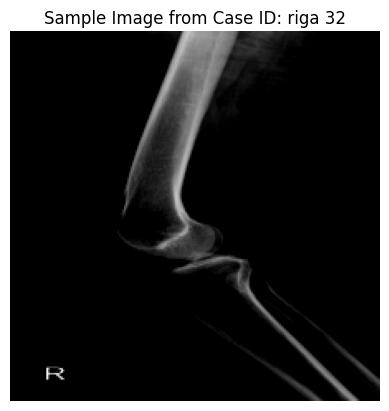

In [11]:
sample_images = sample['pixel_values']
# Display the first image in the sample
if sample_images:
    plt.imshow(sample_images[1].permute(1, 2, 0).numpy())
    plt.axis('off')
    plt.title(f"Sample Image from Case ID: {sample['case_id']}")
    plt.show()